# CmdStanPy Tutorial: do inference over a model conditioned on data


## Overview

The Bayesian workflow provides a framework for model comparison and model expansion.  To facilitate this workflow, CmdStanPy provides a set of objects which manage the model, and the result of doing inference over a model conditioned on data.   The building blocks of a Bayesian data analysis are

 + the model, written as a Stan program
 + the data, i.e., the definitions for all data variables in the Stan program
 + the resulting inferences over the model conditioned on the data:
     + the inference engine configuration, i.e., all arguments to the CmdStan command-line interface
     + the inference engine outputs:  output and diagnostic files, console message, error messages, and process return codes.

#### The model

The CmdStanPy class `CmdStanModel` encapsulates the model.  When working in CmdStanPy, all models must be supplied either as a Stan program file or as a compiled model executable file; or both, in which case, the base filenames must match.   While writing a program as a file requires a text editor, as opposed to the convenience of a Python notebook, in the long run, this is a more efficient way to develop complex models. 

#### The data

Definitions of all data variables in the model are supplied either as a Python dictionary or as an on-disk data file which can be in either JSON or Rdump format.  Python dictionaries are converted to JSON inputs to CmdStanPy.  It is up to the user to save and manage the data; the data itself is not a first-class object in CmdStanPy.


#### Inference Methods

The `CmdStanModel` provides a set of inference methods, each of which returns an inference-specific result class which encapsulates the appropriate information and operations:

 + `sample` - Run the HMC-NUTS sampler to produce a set of draws from the posterior distribution. Returns a `CmdStanMCMC` object which contains all draws from all sampler chains.
 + `optimize` - Produce a penalized maximum likelihood estimate (point estimate) of the model parameters.  Returns a `CmdStanMLE` object containing point estimates for all model variables.
 + `variational` - Run CmdStan’s variational inference algorithm to approximate the posterior distribution. Returns a `CmdStanVB` object containing the approximate estimates.
 + `generate_quantities` - Run CmdStan’s generate_quantities method to produce additional quantities of interest based on each draw from an existing sample. Returns a `CmdStanGQ` object which contains the draws for the generated quantities variables.


#### Output files and logs

The CmdStan interface is entirely file-based, therefore CmdStanPy manages the process of converting in-memory data structures to their file-based representation and vice versa.

Each run of an inference algorithm produces one or more output files in [Stan CSV format](https://mc-stan.org/docs/cmdstan-guide/stan-csv.html), as well as the messages written to stdout and stderr.  CmdStanPy uses per-run directories to keep all files together; the location of the directory can be specified when setting up the run, or it can be specified and/or changed afterwards via the `save_csvfiles` method, common to all inference method classes.

## Installation

CmdStanPy is a pure-Python3 package, but it relies on CmdStan for all
of its functionality. There are several ways to install CmdStan and CmdStanPy, 
which depend on the kind of user you are. 


#### Conda users (Recommended)

If you use [conda](https://docs.conda.io/en/latest/),
installation of both can be done very simply. CmdStanPy
and CmdStan are both available via the 
[conda-forge](https://conda-forge.org/) repository.

We recommend creating a new environment for CmdStan[Py]:

```
conda create -n cmdstan -c conda-forge cmdstanpy
```

but installation is possible in an existing environment:

```
conda install -c conda-forge cmdstanpy
```

These commands will install CmdStanPy, CmdStan, and the
required compilers for using CmdStan on your system inside
a conda environment. To use them, run `conda activate cmdstan`,
or whichever name you used for your environment (following `-n`
above).

Note that CmdStan is only available on conda for versions
2.27.0 and newer. If you require an older version, you must use
one of the following methods to install it. If you require a
version of CmdStan *newer* than 2.27.0, but not the latest,
you can install it in the standard conda way by specifying
`cmdstan==VERSION` in the install command.

#### Pip (non-Conda) users 

CmdStan can also be installed from PyPI via URL: https://pypi.org/project/cmdstanpy/ or from the
command line using `pip`:

```
pip install --upgrade cmdstanpy
```

The optional packages are

* `tqdm` which allows for progress bar display during sampling
* `xarray`, an n-dimension labeled dataset package which can be used for outputs

To install CmdStanPy with all the optional packages:

```
pip install --upgrade cmdstanpy[all]
```

To install the current develop branch from GitHub:

```
pip install -e git+https://github.com/stan-dev/cmdstanpy@/develop#egg=cmdstanpy
```

If you install CmdStanPy from GitHub,
**you must install CmdStan**. The recommended way for Pip users 
to do so is via the `install_cmdstan` function. 

*Note for PyStan & RTools users:*  PyStan and CmdStanPy should be installed in 
separate environments if you are using the RTools toolchain (primarily Windows users).
If you already have PyStan installed, you should take care to install CmdStanPy in its own
virtual environment.


## Hello World:  Compile and run CmdStan example model `bernoulli.stan`

Every CmdStan release has an `examples/bernoulli` directory which contains the Stan model and test data files.  In this example we compile the model and run the NUTS-HMC sampler to obtain the full posterior density.

The `CmdStanModel` class method `sample` invokes Stan's NUTS-HMC sampler which conditions the model on the input data and returns a `CmdStanMCMC` object. The `CmdStanMCMC` object contains the set of draws from the posterior plus metadata.

### Import CmdStanPy classes and methods

In [1]:
import os
from cmdstanpy import cmdstan_path, CmdStanModel

### Compile the model

The CmdStanPy directory `examples/bernoulli` contains the model and data files.

In [2]:
bernoulli_dir = os.path.join(cmdstan_path(), 'examples', 'bernoulli')
stan_file = os.path.join(bernoulli_dir, 'bernoulli.stan')
with open(stan_file, 'r') as f:
    print(f.read())

data {
  int<lower=0> N;
  array[N] int<lower=0,upper=1> y; // or int<lower=0,upper=1> y[N];
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);  // uniform prior on interval 0,1
  y ~ bernoulli(theta);
}



The `CmdStanModel` object stores the filepaths of the Stan program and the compiled executable file.  By default, if no executable file is supplied, or if the timestamp on the model file is newer than the timestamp on the executable file, the model will be compiled on instantiation.

In [3]:
model = CmdStanModel(stan_file=stan_file)
print(model)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/mitzi/.cmdstan/cmdstan-2.27.0/examples/bernoulli/bernoulli


CmdStanModel: name=bernoulli
	 stan_file=/Users/mitzi/.cmdstan/cmdstan-2.27.0/examples/bernoulli/bernoulli.stan
	 exe_file=/Users/mitzi/.cmdstan/cmdstan-2.27.0/examples/bernoulli/bernoulli
	 compiler_options=stanc_options={}, cpp_options={}


### Assemble the data

Input data is either a Python `Dict` with entries corresponding to input data values, or it can be a file in JSON or Rdump format.

If a `Dict` is specified, CmdStanPy writes it to a temp file in JSON format.

In [4]:
data = { "N" : 10, "y" : [0,1,0,0,0,0,0,0,0,1] }

In the CmdStan `examples/bernoulli` directory, there are data files in both `JSON` and `rdump` formats.

In [5]:
data_file = os.path.join(bernoulli_dir, 'bernoulli.data.json')
with open(data_file, 'r') as f:
    print(f.read())

{
    "N" : 10,
    "y" : [0,1,0,0,0,0,0,0,0,1]
}



### Do Inference

The `CmdStanModel` class `sample` method runs the HMC-NUTS sampler to produce a set of draws from the posterior distribution.  By default, `sample` runs 4 sampler chains.

In [6]:
fit = model.sample(data=data)
print(fit)

INFO:cmdstanpy:sampling: ['/Users/mitzi/.cmdstan/cmdstan-2.27.0/examples/bernoulli/bernoulli', 'id=1', 'random', 'seed=38472', 'data', 'file=/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/g0usu3yz.json', 'output', 'file=/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-1-js2crwjc.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:sampling completed


CmdStanMCMC: model=bernoulli chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-1-js2crwjc.csv
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-2-bs65mqc0.csv
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-3-ovs93_pk.csv
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-4-b8uhke8q.csv
 output_files:
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-1-js2crwjc-stdout.txt
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-2-bs65mqc0-stdout.txt
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-3-ovs93_pk-stdout.txt
	/var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-4-b8uhke8q-stdout.txt


### Access the sample: the `CmdStanMCMC` object attributes and methods

The CmdStanMCMC class has properties and methods to access the sampler outputs and all metadata.  Accessor properties include:

- `draws`  - all draws from all chains, stored as a 3-D numpy.ndarray.
- `num_draws` - total number of warmup and sampling draws
- `chains` - number of chains run by sampler
- `metric`, `step_size` - per-chain HMC tuning parameters
- `csv_files` - list of Stan csv output files which comprise the sample
    
The `draws` array is created only as needed; therefore the first time that this property is accessed, CmdStanPy parses the set of csv output files, at the same time it parses the contain step size and metric information.  Depending on the size of the sample and your computing environment, this may take a few seconds or more.

The numpy ndarray is stored column major format so that values for each parameter are stored contiguously in memory, likewise all draws from a chain are contiguous.  Thus the dimensions of the ndarray are arranged as follows:  (draws, chains, columns).  The draws array contains both the sampler variables and the model variables.  Sampler variables report the sampler state.  For the NUTS-HMC sampler, there are 7 reported variables, all of which end in `__`.  The example model contains a single variable `theta`.

In [7]:
fit.draws().shape

(1000, 4, 8)

#### Viewing the sample as a set of variables:  sampler variables and program variables

The `CmdStanMCMC` property `draws` is a 3-D numpy ndarray which contains all draws across all chains.  
    
- `stan_variables` - dictionary mapping Stan program variables names to the draws for that variable.
- `sampler_variables` - dictionary mapping the sampler variables names, (e.g., `lp__`) to the draws for that variable.

theta (4000,)


<AxesSubplot:ylabel='Density'>

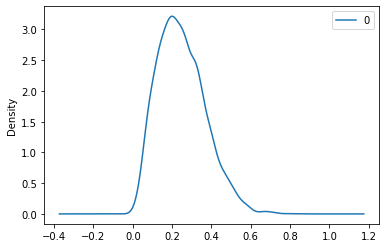

In [8]:
%matplotlib inline
import pandas as pd

vars = fit.stan_variables()
for (k,v) in vars.items():
    print(k, v.shape)

thetas = fit.stan_variable(var='theta')
pd.DataFrame(data=thetas).plot.density()

#### Get HMC sampler tuning parameters

##### step_size

The `CmdStanMCMC` property `step_size` property is a 1-D numpy ndarray which contains the step size used by the sampler for each chain.  This array is created at the same time as the `sample` and `metric` arrays are created.

At the end of adaptation, the step size for the 4 chains in this example is:

In [9]:
fit.step_size

array([0.873254, 0.781459, 1.20786 , 0.937012])

#### metric_type, metric

The `metric` property is an numpy ndarray which contains the metric used by the sampler for each chain.  This array is created at the same time as the `sample` and `step_size` arrays are created.

At the end of adaptation, the metric for the 4 chains in this example is:

In [10]:
fit.metric_type,  fit.metric

('diag_e',
 array([[0.484995],
        [0.591301],
        [0.452482],
        [0.609471]]))

#### Summarize the results

The `CmdStanMCMC` method `summary` runs the CmdStan `bin/stansummary` over the fitted sample csv files.  The output of the command is streamed to the console.  The method returns a pandas.DataFrame which contains
estimates of posterior means, standard deviations, Monte-Carlo standard error, effective sample size, and convergence diagnostic statistic for all parameters, transformed parameters, and generated quantities variables:

In [11]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.30,0.020,0.78,-8.800,-7.00,-6.80,1500.0,28000.0,1.0
theta,0.25,0.003,0.12,0.075,0.24,0.47,1700.0,32000.0,1.0


#### Run sampler diagnostics

The `CmdStanMCMC` method `diagnose` prints the output of CmdStan bin/stansummary to the console.  This is useful when the summary report shows `R_hat` values outside of the range of .99 to 1.01, or the number of effective samples (`N_eff` value) is below 5% of the total draws in the sample.   It returns a string which contains the console output.


   + The `CmdStanMCMC` class method `diagnose` invokes CmdStan's `diagnose` utility which checks for the following problems:
    + transitions that hit the maximum treedepth
    + divergent transitions
    + low E-BFMI values (sampler transitions HMC potential energy)
    + low effective sample sizes
    + high R-hat values
   + See the Stan reference manual section on [posterior analysis](https://mc-stan.org/docs/reference-manual/analysis-chapter.html) for further details.



In [12]:
diags = fit.diagnose()

Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-1-js2crwjc.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-2-bs65mqc0.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-3-ovs93_pk.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-4-b8uhke8q.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


In [13]:
print(diags)

Processing csv files: /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-1-js2crwjc.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-2-bs65mqc0.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-3-ovs93_pk.csv, /var/folders/db/4jnggnf549s42z50bd61jskm0000gq/T/tmpki9l1wdc/bernoulli-20210928140611-4-b8uhke8q.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.

